# SARFish MLP Vessel Length Regressor

## 1. Setup

In [1]:
# Better error messages in notebooks
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent # Get to project root from notebook location
sys.path.append(str(PROJECT_ROOT / "src")) # Add "src" to Python's module search path sys.path

import pickle
import tensorflow as tf
from tensorflow import keras
from mlp_vessel_regressor import *
from du_utilities import *

2025-10-13 22:12:39.984105: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Data loading and inspection

In [3]:
# Load the data
(X_train, y_train, X_val, y_val, X_test, y_test) = pickleload("../runs/vlength/rf/20251009_1826/rf_reg_unnorm_dual_no_aug_conf-filtered.pkl")

In [4]:
# Check shape and range of each data split
print(f"X_train: {np.shape(X_train), np.min(X_train), np.max(X_train)}, y_train: {np.shape(y_train),np.min(y_train), np.max(y_train)}")
print(f"X_val:   {np.shape(X_val), np.min(X_val), np.max(X_val)},  y_val: {np.shape(y_val),np.min(y_val), np.max(y_val)}")
print(f"X_test:  {np.shape(X_test), np.min(X_test), np.max(X_train)},  y_test: {np.shape(y_test),np.min(y_test), np.max(y_test)}")

X_train: ((3092, 3), 0.0, 1.0), y_train: ((3092,), 6.96, 343.4)
X_val:   ((459, 3), 0.0, 1.0),  y_val: ((459,), 9.99, 240.1687969)
X_test:  ((229, 3), 0.0, 1.0),  y_test: ((229,), 13.36914283, 274.3977876)


In [5]:
# inspect the min and max values of each feature
np.min(X_train, axis=0), np.max(X_train, axis=0)

(array([0.052083, 0.010417, 0.      ]), array([1.      , 0.552083, 1.      ]))

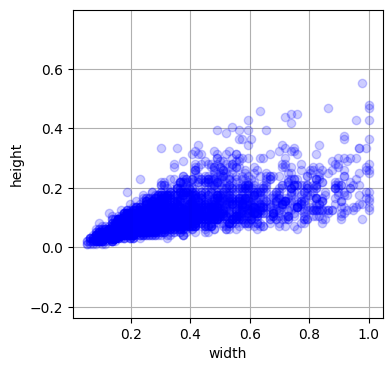

In [6]:
plt.figure(figsize=(4, 4))
plt.plot(X_train[:,0], X_train[:,1], 'bo', alpha=0.2)
plt.axis('equal')
plt.xlabel('width')
plt.ylabel('height')
plt.grid('on')

In [7]:
for c in range(2):
    print(f'Number of training instances for class {c}: {np.sum(X_train[:,-1] == c)}')

Number of training instances for class 0: 2323
Number of training instances for class 1: 769


In [8]:
for c in range(2):
    bool = X_train[:,-1] == c
    print(f'Class {c}: vessel length range = '
          f'({np.min(y_train[bool]):5.3f}, {np.max(y_train[bool]):5.3f})')

Class 0: vessel length range = (9.810, 343.400)
Class 1: vessel length range = (6.960, 86.800)


In [9]:
sample_weight = np.zeros(y_train.shape)
# class 0 is the under-represented class, give samples for this
# class a weight value of 1; samples for class 1 have weight value 0.8.
for c,w in zip(range(2), [1.0, 0.8]):
    indices = np.where(X_train[:,-1] == c)[0]
    sample_weight[indices] = w

## 3. Model training

In [21]:
# Reset the name counters
tf.keras.backend.clear_session()

In [22]:
# Create model architecture
def du_create_mlp_model(input_dim=4, hidden_layers=[32,16,8], scale=100., offset=0., activation="relu"):
    layers = [tf.keras.layers.InputLayer(shape=[input_dim])]
    
    for units in hidden_layers:
        layers.append(tf.keras.layers.Dense(units, activation=activation))
        # layers.append(tf.keras.layers.BatchNormalization())

    # Output layer
    layers.append(tf.keras.layers.Dense(1)) 
    layers.append(tf.keras.layers.Rescaling(scale=scale, offset=offset))  # with the current scale and offset this does nothing
    model = tf.keras.models.Sequential(layers)
    return model
    
model = du_create_mlp_model(input_dim=3, hidden_layers=[32,16,8,4], scale=1.0)

In [23]:
# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             5 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833 (3.25 KB)

 Trainable params: 833 (3.25 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Setup target (vessel length) for scaling
# y_scaler, y_train_scaled = setup_target_scaler(y_train)
# y_val_scaled = y_scaler.transform(y_val.reshape(-1, 1)).flatten()

In [25]:
# Create custom loss function - Absolute Relative Error (scaled)
# loss_function = create_custom_loss(y_scaler)

def loss_function(ytrue, ypred):
    return tf.abs(ytrue - ypred) / ytrue

In [26]:
# Power scheduler
power_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=1e-2,
    decay_steps = 4000,
    decay_rate = 0.2,
    staircase = True
)

In [27]:
# Compile with custom ARE loss and SGD optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=power_schedule)
model.compile(loss=loss_function, optimizer=optimizer, metrics=['mae'])

In [28]:
# Setup VLA and model checkpoint callbacks
# checkpoint_path = './models/mlp/best_model.keras'
# callbacks = create_callbacks(checkpoint_path, X_val, y_val, y_scaler, vla_freq=5)

In [29]:
# Train model
tf.random.set_seed(42)

callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, 
                                            restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=500,
    shuffle=True,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    sample_weight=sample_weight,
    verbose=0
)

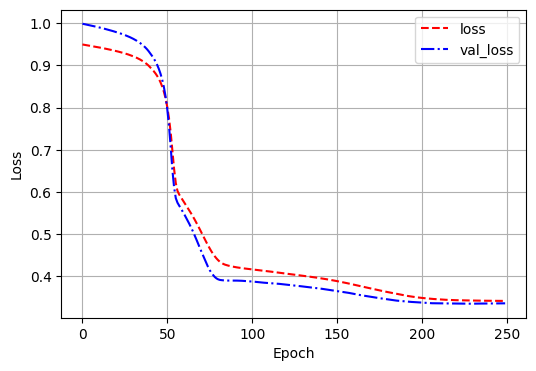

In [30]:
# Plot learning curves
fig = plot_learning_curves(history, title=None, figsize=(6, 4))

In [31]:
#save_fig(fig_name="mlp_reg_loss20251013_2208_dual_no_aug", fig_extension="pdf", resolution=300, fig=fig)

Figure saved as: mlp_reg_loss20251013_2208_dual_no_aug.pdf


In [32]:
#model.save("mlp_model_20251013_2208_dual_no_aug.keras")

## 4. Model evaluation

In [ ]:
#model = keras.models.load_model("../runs/vlength/mlp/mlp_model_20251010_0932_dual_no_aug.keras", custom_objects={'loss_function': loss_function})

In [33]:
# y_train_pred = make_predictions(best_model, X_train, y_scaler)
# y_val_pred = make_predictions(best_model, X_val, y_scaler)
# y_test_pred = make_predictions(best_model, X_test, y_scaler)

# ravel() flattens the 1-column matrices to vectors
y_train_pred = model(X_train).numpy().ravel()
y_val_pred = model(X_val).numpy().ravel()
y_test_pred = model(X_test).numpy().ravel()

In [34]:
# Calculate and display metrics for each split
train_mlp_metrics = calculate_metrics_by_class(y_train, y_train_pred, X_train[:, -1], "Training")
#val_mlp_metrics = calculate_metrics_by_class(y_val, y_val_pred, X_val[:, -1], "Validation")
test_mlp_metrics = calculate_metrics_by_class(y_test, y_test_pred, X_test[:, -1], "Test")


=== Training Metrics ===
Overall      MAE:  27.15, R²:  0.521, VLA:  0.643
is_vessel    MAE:  33.36, R²:  0.347, VLA:  0.622 (n=2323)
is_fishing   MAE:   8.40, R²: -0.027, VLA:  0.706 (n=769)

=== Test Metrics ===
Overall      MAE:  26.84, R²:  0.592, VLA:  0.631
is_vessel    MAE:  32.43, R²:  0.443, VLA:  0.619 (n=173)
is_fishing   MAE:   9.55, R²: -0.738, VLA:  0.669 (n=56)


Plot saved to /home/peterm/UWA/CITS5014/SARFish/modelling/runs/vlength/mlp/mlp_vlen_plots_20251014_1904.pdf


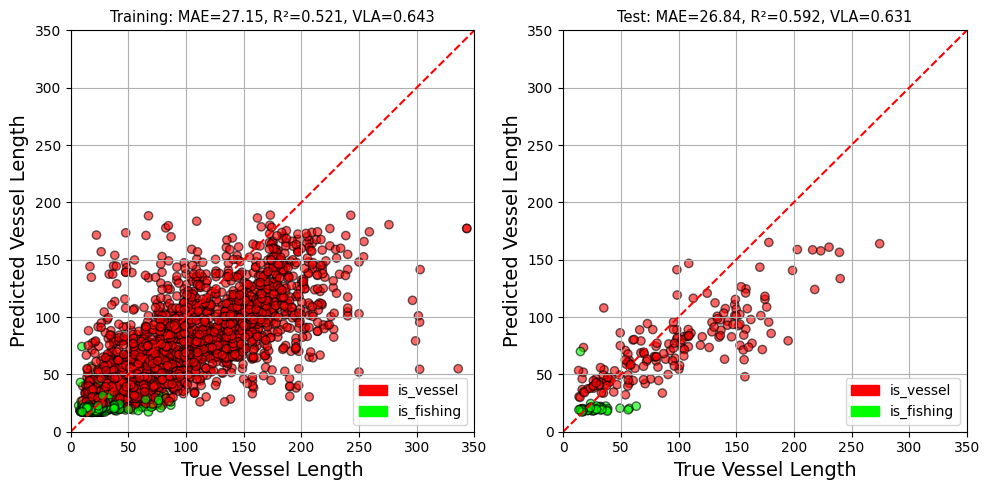

In [35]:
# Display predicted versus true vessel length plots for each split (use the rf regressor plot function)

# Prepare plot data dictionary - extract 'overall' metrics
plot_data = {
    'train_true': y_train, 'train_pred': y_train_pred,
    #'val_true': y_val, 'val_pred': y_val_pred,
    'test_true': y_test, 'test_pred': y_test_pred,
    'train_metrics': train_mlp_metrics['overall'],
    #'val_metrics': val_mlp_metrics['overall'],
    'test_metrics': test_mlp_metrics['overall'],
    'train_classes': X_train[:, -1],
    #'val_classes': X_val[:, -1],
    'test_classes': X_test[:, -1]
}

# Generate all three plots side by side
plot_results(plot_data, save_path='mlp_vlen_plots_20251014_1904.pdf', log_dir=f"/home/peterm/UWA/CITS5014/SARFish/modelling/runs/vlength/mlp/")